# pill 5 - Opening the black-box and solutions to overfitting

<div class = "alert alert-danger" style = "border-radius:10px">**DEPENDENCIES:** `ipywidgets` dependency.</div>

<div class = "alert alert-danger">**CODE DEPENDENCY:**  `cvxpy`</div>

In MAC Sierra it may fail compilation:

solution: run in a terminal `xcode-select --install` to install command line tools

## 1. Disectioning machine learning methods

In order to be able to learn, any algorithm has to define at least three components:

+ **The model class/hypothesis space** defines the family of mathematical models that will be used. The target decision boundary will be approximated from one element of this space. For example, we can consider the class of linear models. In this case our decision boundary will be a line if the problem is defined in ${\bf R}^2$ and the model class is the space of all posible lines in ${\bf R}^2$. 

    Model classes define the geometric properties of the decision function. There are different taxonomies but the most well-known are the *families* of **linear** and **non-linear** models. These families usually depend on some parameters. And the solution to a learning problem is the selection of a particular set of parameters, i.e. the selection of an instance model from the model class space. The model class space is also called **hypothesis space**.

    The selection of the best model will depend on our problem and what we want to obtain from the problem. The primary goal in learning is usually achieving the minimum error/maximum performance. But according to what else we want from the algorithm we will find different algorithms. Other common desirable properties are interpretability, behavior in front of missing data, fast training, etc.


+ **The problem model** formalizes and encodes the desired properties of the solution. In many cases this formalization takes the form of an optimization problem. In it most basic instantiation, the problem model can be the **minimization of an error function**. The error function measures the difference between our model and the target one. Informally speaking, in a classification problem it measures how "irritated" we are when our model misses the right label of a training sample. For example, in classification the ideal error function is the **0-1 loss**. This function takes value $1$ when we incorrectly classify a training sample and zero otherwise. In this case, it can be intrepreted that one is only irritated by "one unit of irritation" when one sample is misclassified.

    Problem model can also be used to impose other constraints on our solution, such as finding a smooth approximation, small complexity model, sparse solution, etc.
    
    
+ **The learning algorithm** is an optimization/search method or algorithm that given a model class fits it to the training data according to the error function. According to the nature of our problem there are many different algorithms. In general, we are talking about finding the minimum error approximation or maximum probable model. In those cases, if the problem is convex/quasi-convex we will typically use first or second order methods (i.e. gradient descent, coordinate descent, Newton's method, Interior Point methods, etc). Other searching techniques such as genetic algorithms or monte-carlo techniques can be used if we do not have access to the derivatives of the objective function.


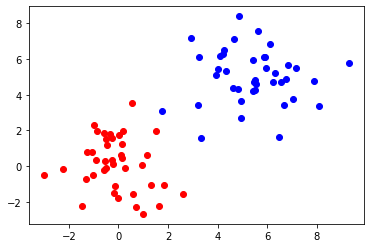

In [1]:
%matplotlib inline
#from sklearn import 
import numpy as np
#Create some data
X = np.concatenate([1.25*np.random.randn(40,2),5+1.5*np.random.randn(40,2)]) 
y = np.concatenate([np.ones((40,1)),-np.ones((40,1))])

#Visualize
import matplotlib.pyplot as plt
plt.scatter(X[0:40,0],X[0:40,1],color='r')
plt.scatter(X[40:,0],X[40:,1],color='b')

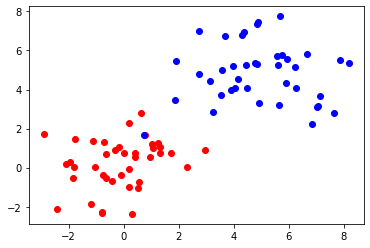

interactive(children=(FloatSlider(value=0.0, description='w0', max=10.0, min=-10.0), FloatSlider(value=0.0, de…

In [4]:
#from sklearn import 
import numpy as np
#Create some data
X = np.concatenate([1.25*np.random.randn(40,2),5+1.5*np.random.randn(40,2)]) 
y = np.concatenate([np.ones((40,1)),-np.ones((40,1))])

#Visualize
import matplotlib.pyplot as plt
from IPython.html.widgets import interact

def human_learning_algorithm(X,y):
    
    plt.scatter(X[0:40,0],X[0:40,1],color='r')
    plt.scatter(X[40:,0],X[40:,1],color='b')
    #plt.scatter(X[0:40,0],X[0:40,1],color='r')
    #plt.scatter(X[40:,0],X[40:,1],color='b')    
    delta = 0.025
    xx = np.arange(-5.0, 10.0, delta)
    yy = np.arange(-5.0, 10.0, delta)
    XX, YY = np.meshgrid(xx, yy)
    Xf = XX.flatten()
    Yf = YY.flatten()
    sz=XX.shape
    data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1);

    def hml_display(w0,w1,offset):
        w=np.array([w0,w1])
        w.shape=(2,1)
        #Evaluate the model for a given weight
        Z = data.dot(w)+offset
        Z.shape=sz
        plt.scatter(X[0:40,0],X[0:40,1],color='r')
        plt.scatter(X[40:,0],X[40:,1],color='b')
        plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,10,-5,10),alpha=0.3, vmin=-15, vmax=15)
        plt.contour(XX,YY,Z,[0])
        fig = plt.gcf()
        fig.set_size_inches(9,9)
   
    #Ipython 2.0      
    interact(hml_display, w0=(-10.,10.), w1=(-10.,10.), offset=(-20.,40.));
    #Ipython 1.1 back compatibility
    #w0=-10. #-10.,10.
    #w1=-10. #-10.,10.
    #offset=-20. #-20.,40.
    #hml_display(w0,w1,offset) 

    
human_learning_algorithm(X,y)



<div class = "alert alert-success" style = "border-radius:10px">**QUESTION:** Describe the process you used for fitting the classifier
</div>

<div class = "alert alert-info" style="border-radius:10px">**Some notes on the learning process**
<p>
The main goal of any learning process is to achive the maximum predictive power (*accuracy*). This is minimize the error. However, there are three other important properties we usually desire our models to have:

<p>
<li> **Simplicity** - how much fiddling do we need for the method to work? Can I modify it to handle the particularities of my problem?
<li> **Speed** - How long does it take to train a reliable model? (training time) Can I use it in embedded and real time applications? (testing time), How long do I have to wait for processing my 1YB (yottabyte - 1e24 Bytes) dataset?
<li> **Interpretability** - Why did it make this predictions?

<p>
It happens that accuracy trades off with all the rest of the desirable properties. 
</div>

In general, we can represent the problem of supervised machine learning as in the following scheme:

<img src = "./files/learning_problem-eps-converted-to.jpg" width = 400px>

## 2. First steps into a model: Linear regression

Consider a two dimensional problem such as the following. 

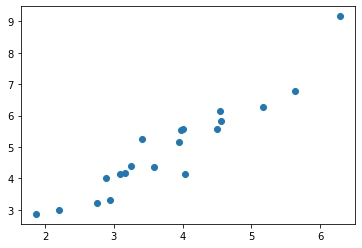

In [1]:
import numpy as np
np.random.seed(2)
x = 4+np.random.normal(size=(20,1))
y = 0.5 + 1.2*x + 0.5*np.random.normal(size=(20,1))

%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(x,y)

In every problem we have to decide the **model class**, the **cost function**, and the **learning/searching algorithm**.

In this problem we could decide to use as **model class** the set of *linear models*, i.e. $$\mathcal{H}(w_0,w_1) = \hat{y} = w_1 x + w_0,$$
where $w_1$ and $w_0$ are the parameters of the model. 

Our **cost function** could be the *mean least squares* function, i.e. $$\mathcal{L}(y_i,\hat{y}_i) = \frac{1}{N}\sum_{i=0}^N (y_i - \hat{y}_i)^2$$, where $\hat{y}$ is the predicted value.

Using these two elements we can model the problem of learning as:

$$
\begin{align}
\underset{w_0,w_1}{\text{minimize}}&& \frac{1}{N}\sum_{i=0}^N (y_i - (w_1x_i + w_0))^2.
\end{align}
$$



Our last component is the way of solving this problem. Fortunately for us we know about *optimization* and *numerical linear algebra*. Thus we can proceed in different directions. 

Let us start with using a very simple and intuitive idea:

<ol>
<li>Start with a random point, ${\bf w}^0$.</li>
<li>Change the parameters in such a way that we reduce the cost function</li>
$$\mathcal{L}({\bf w}^{t})\leq \mathcal{L}({\bf w}^{t-1})$$
<li>Repeat until we can not reduce the cost function</li>
</ol>
    

Let us refine the process
<ol>
<li>Start with a random point, ${\bf w}^0$.</li>
<li>Select a descent direction $\Delta {\bf w}$ and a step size $\eta$ (this last can be selected by line search).</li>
<li>Update the parameters:</li>
$$ {\bf w}^{t} = {\bf w}^{t-1} + \eta \Delta {\bf w}$$

<li>Repeat 2-3 until the stoping criterion is met (This can be a certain number of iterations or a desired error tolerance).</li>
</ol>

The most well known technique in this kind of techniques is **Steepest descent** or **Gradient descent**, where $\Delta {\bf w} = -\nabla_{\bf w} \mathcal{L}$.

In order to solve the problem we have to compute the gradient of the loss function. We can easily derive the expression considering matrix calculus. Let us express the linear model as the inner product of the parameters and the data point. For the sake of simplicity consider an extended data example as 

$$\tilde{\bf x} = \left(\begin{matrix} 1\\ {\bf x} \end{matrix}\right)$$


thus

$$\hat{y} = \sum_{i=1}^d w_i x^{(i)} + w_0 = \sum_{i=0}^d w_i \tilde{x}^{(i)} = \tilde{\bf x}^T {\bf w}.$$

Moreover, given a data set with $N$ data points, where each one is stored as a column vector, we can define the design matrix as 

$${\bf X} = (x_1, \dots x_N).$$

then, the output of our model for the whole data set is a prediction vector defined as

$$\hat{\bf y} = \tilde{\bf X}^T {\bf w}.$$

The loss function can also be expressed as a matrix product,

$$\mathcal{L}(y_i,\hat{y}_i) = \frac{1}{N}\sum_{i=0}^N (y_i - \hat{y}_i)^2 = \frac{1}{N} ({\bf y}-\hat{\bf y})^T({\bf y}-\hat{\bf y})$$

Thus our problem can be rewriten as 

$$
\begin{align}
\underset{{\bf w}}{\text{minimize}}&& \frac{1}{N}({\bf y}-\tilde{\bf X}^T {\bf w})^T({\bf y}-\tilde{\bf X}^T {\bf w}).
\end{align}
$$

We can differentiate this expression with respect the vector ${\bf w}$, considering the following rule 

$$\partial (A B) = \partial(A) B= + (A \partial (B))^T.$$

then

$$\nabla_{\bf w} \mathcal{L} = - \frac{2}{N} \tilde{\bf X}({\bf y}-\tilde{\bf X}^T {\bf w}).$$

<div class = "alert alert-danger" style= "border-radius:10px"> **EXERCISE/QUIZ:** Code a basic gradient descent for the problem. What is the value optained for $\eta=0.01$ and 50 iterations if we initialize the weights to $(0,0)$? (Write down your solution, it will be asked for in the quiz later).
</div>

quocient is large enough it breaks the behaviour
reductin training error



In [2]:
#your code here

n_iter = 50
learning_rate = 0.01
N = x.shape[0]
x_augmented = np.c_[np.ones((x.shape[0],1)),x].T
w = np.zeros((2,1))
objective=np.zeros((n_iter,1))

for i in range(n_iter):
    #COMPLETE GRADIENT DESCENT HERE


SyntaxError: unexpected EOF while parsing (<ipython-input-2-5bd34ab6e7ad>, line 11)

In [ ]:
# Run this code to compute the value for the quiz

assert w.shape==(2,1), 'The shape of the answer must be (2,1)'

w_opt = np.array([[0.5],[1.2]])
d = np.sqrt(np.dot((w_opt-w).T,(w_opt-w)))
print('The distance between w* and the obtained w is: '+ str(d))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(objective)

<div class = "alert alert-danger" style= "border-radius:10px"> **EXERCISE/QUIZ:** Let us speed up the algorithm using a larger step. Solve the problem using the same code and $\eta=0.1$  and 100 iterations (starting point still the zero vector). What is the resulting value of the optimal parameters?
</div>

In [ ]:
# Your code here

<div class = "alert alert-danger" style= "border-radius:10px"> **EXERCISE/QUIZ:** Repeat the former exercise but compute the value of the objective function at each iteration and plot it. This is called "convergence plot".
</div>

## Closed form solution for  least squares linear regression

Fortunately for us, this problem has a close form solution. As you may recall from optimization the condition for a point being an extremum is 

$$\nabla_{\bf w} \mathcal{L} = 0$$

In this problem, we can write

$$ - \frac{2}{N} \tilde{\bf X}({\bf y}-\tilde{\bf X}^T {\bf w}) = 0 $$

which, with simple manipulation gives us the following answer:

$${\bf w} = (\tilde{\bf X}\tilde{\bf X}^T)^{-1}\tilde{\bf X}{\bf y}$$

<div class = "alert alert-danger" style= "border-radius:10px"> **EXERCISE/QUIZ:** Repeat the former exercise using the analytic solution and write down the value for the quiz.
</div>

In [ ]:
#your code here

import numpy as np

x_augmented = np.c_[np.ones((x.shape[0],1)),x].T

#USE STANDARD LINEAR ALGEBRA HERE (np.linalg.pinv for the pseudo inverse)

In [ ]:
# Run this code to compute the value for the quiz

assert w.shape==(2,1), 'The shape of the answer must be (2,1)'

w_opt = np.array([[0.5],[1.2]])
d = np.sqrt(np.dot((w_opt-w).T,(w_opt-w)))
print('The distance between w* and the obtained w is: '+ str(d))

## A comparison between both solvers

<table>
<tr><td>Iterative methods</td><td>Analytic solution</td></tr>
<tr><td>
<ul>
<li>Need to choose the learning rate $\eta$. </li>
<li>May be slow.</li>
<li>Each iteration is usually cheap.</li>
<li>Can be used with large data sizes.</li>
</ul>
</td><td>
<ul>
<li>Looks nicer</li>
<li>"No iterations are required"</li>
<li>Large computational cost. In the simplest case where we need matrix inversion, a naive method would need $O(n^3)$</li>
</ul>
</td>
</tr>
</table>

# Combating overfitting

Outline:

+ Introduction to regularization
+ Early stopping 
+ Norm regularizers
+ Data augmentation and dropout


# The toy problem

Let us take our well known toy problem 

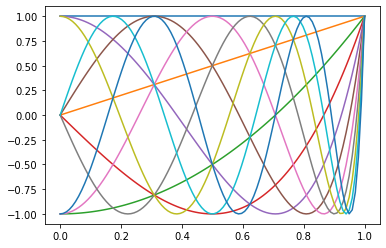

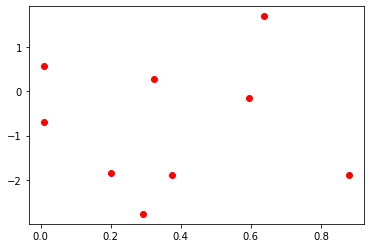

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def polyval(coefs, x):
    res = coefs[0]*np.ones((1,x.shape[0]))
    for i in range(1,len(coefs)):
        res = res + coefs[i]*np.power(x,i)
    return res
        

def chebys (coefs, x):
    pol = {}
    pol[0] = [1][::-1]
    pol[1] = [1, 0][::-1]
    pol[2] = [2, 0, -1][::-1]
    pol[3] = [4, 0, -3, 0][::-1]
    pol[4] = [8, 0, -8, 0, 1][::-1]
    pol[5] = [16, 0, -20, 0, 5, 0][::-1]
    pol[6] = [32, 0, -48, 0, 18, 0, -1][::-1]
    pol[7] = [64, 0, -112, 0, 56, 0, -7, 0][::-1]
    pol[8] = [128, 0, -256, 0, 160, 0, -32, 0, 1][::-1]
    pol[9] = [256, 0, -576, 0, 432, 0, -120, 0, 9, 0][::-1]
    pol[10] = [512, 0, -1280, 0, 1120, 0, -400, 0, 50, 0, -1][::-1]
    pol[11] = [1024, 0, -2816, 0, 2816, 0, -1232, 0, 220, 0, -11, 0][::-1]

    res = np.zeros((1,x.shape[0]))

    for i in range(len(coefs)):
        res= res + coefs[i]*polyval(pol[i],x)
    return res

        
x = np.linspace(0,1,100)

%matplotlib inline
import matplotlib.pyplot as plt

for i in range(11):
    co = np.zeros((11,))
    co[i]=1.
    plt.plot(x,chebys(co,x).ravel())
    
#Create a polynomial with noise
np.random.seed(42)
coefs = np.random.random(11)

x = np.linspace(0,1,100)

vals=chebys(coefs,x).ravel()
#plt.plot(x,vals)

N=9
idx = np.random.randint(0,100,N)
data = vals[idx]+1.*np.random.normal(size=len(idx))
plt.figure()
plt.plot(x[idx],data,'ro')

x_train = x[idx][:,np.newaxis]
y_train = data[:,np.newaxis]

In [4]:
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

(-10.0, 10.0)

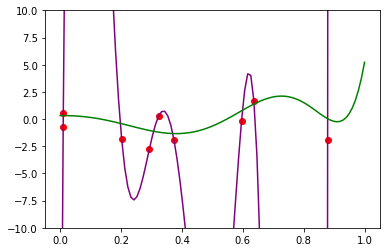

In [5]:
w_analytic = np.dot(np.linalg.pinv(np.dot(X,X.T)),np.dot(X,y_train))
x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,w_analytic)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])

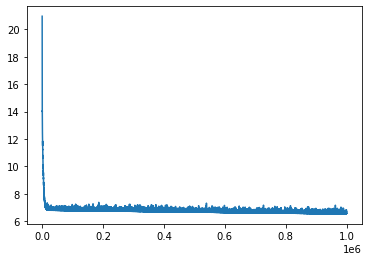

In [6]:
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

import numpy as np

#initialize weights
w = np.zeros((11,1))
conv = []
wpath = []
wpath.append(w)
n_iters = 1000000
Jopt = 9e16
wopt = w
mbatch_size=2
step = 0.01
epsilon = 1e-16
D = np.zeros((11,1))
m = w
g1 = 0.9
g2 = 0.999
for k in range(1,n_iters):
    #get a noisy gradient by just taking one data point at random and get the instantaneous gradient
    i = np.random.randint(0,X.shape[1],size=mbatch_size)
    x_sample = X[:,i]
    y_sample = y_train[i,:]
    #x_sample = X
    #y_sample = y_train
    g_tilde = -2*np.dot(x_sample,(y_sample-np.dot(x_sample.T,w)))
    #m = g1*m - g_tilde
    #w = w + step * m
    if k%(n_iters/3.)==0:
        step = step/5.
    m = g1*m - (1-g1)*g_tilde
    D = g2*D + (1-g2)*g_tilde*g_tilde
    w = w  + step * m / np.sqrt(D + epsilon)
    
    
    #Keep the best weight up to that point 
    J=np.sum((np.dot(X.T,w)-y_train)*(np.dot(X.T,w)-y_train))
    if J<Jopt:
        wopt = w
        Jopt = J
    conv.append(J)
    #Project if needed
    ## Add your projection code here
    
plt.plot(conv)
#plt.gca().set_ylim([0.,5.])

(-10.0, 10.0)

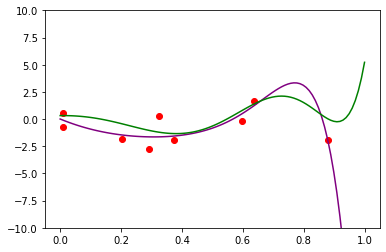

In [7]:
x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,wopt)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])

In [8]:
print (np.abs(np.sum(w.T-w_analytic.T)))

18566.364401854924


In [ ]:
# Early stoping 

<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE: ** Change the value of `n_iters` to $100000$, $10000$, $1000$, $100$, and $10$. Create a plot with the in-sample and the out-of-sample values for the former problem. What is the effect of not letting the method converge?
</div>

In [ ]:
#your code here

# Combating overfitting

The reasoning on how to cure overfitting comes from the very well known bound
$$E_{out}\leq E_{in} + \mathcal{O}(\sqrt{\frac{C}{N}})$$

We want to control the out-of-sample error, thus we have a couple of routes to take:

1. Either we simulate the out-of-sample error and check against unseen data. This is working directly with the left hand side of the inequality. We can do this using **cross-validation**.
2. We change the learning objective to take into account and minimize the complexity of the model. We mimick the right hand side of the inequality and add to the objective function a term penalizing complexity. This is called **regularization**.

3. We can use **ensemble techniques**. Implicitly this strategy is similar to the complexity control technique.

# Regularization

Regularization tries to explicitly model the complexity of the model. In simple words, you give information to the optimization process telling what model you prefer in the absence of data (we can see this as a kind of bias).



## Combating overfitting with norms: A matter of balls

The definition of complexity of a model is ambiguous. Does it mean that it depends on a few elements of a basis? Is it related to the smoothness of the solution? The norm of a vector 

>In linear algebra, functional analysis, and related areas of mathematics, a norm is a function that assigns a strictly positive length or size to each vector in a vector space—save for the zero vector, which is assigned a length of zero. - *Wikipedia*

A very well known norm to use is $\ell_p$ norm, defined as

$$\|\alpha\|_p = \big(\sum_i |\alpha_i|^p\big)^{1/p}$$

Let us have a look at some of them,

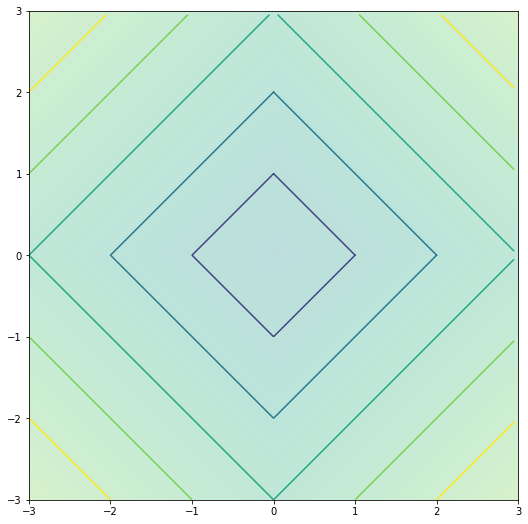

In [9]:
#order = np.Inf
order = 1
delta = 0.05
xx = np.arange(-3.0, 3.0, delta)
yy = np.arange(-3.0, 3.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1)
Z = np.linalg.norm(data,ord = order,axis = 1)
Z.shape=sz
plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-3,3,-3,3),alpha=0.3, vmin=-10, vmax=10)
plt.contour(XX,YY,Z,[0,1,2,3,4,5])
fig = plt.gcf()
fig.set_size_inches(9,9)

<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE: ** Change the value of `order` to $0.5$, $1$, and `np.Inf`. Consider that we add a norm of the desired order to the linear regression problem. What is the expected effect of each of the norms?</div>

<div class = "alert alert-info" style = "border-radius:10px"> **ABOUT $\ell_1$ and $\ell_2$: **Observe that when we move over the norm isosurface this tells us what happends when one increases the value of one parameter to the value of the rest. For example in $\ell_2$ norms if you increase the value of one parameter you decrease the value of the other by a little. How much? 
<p>
Consider the point ${\bf x} = (x_1,x_2)$ with $\|x\|_2 = 1$. Let us perturbe one of the elements and find out what happens to the other so that the norm is constant, ${\bf x'} = (x_1+\epsilon,x_2+\delta)$ with norm $\|x'\|_2 = x_1^2+\epsilon^2+2x_1\epsilon + x_2^2 + \delta^2 + 2x_2\delta = 1$. Observe that because $\|x\|_2 = 1$ we have that $\delta^2 + 2x_2\delta +\epsilon^2+2x_1\epsilon = 0$ with solutions 

$$\delta = -2x_2\pm \sqrt{4 x_2 - 4 (\epsilon^2+2x_1\epsilon)}$$

If $\|x\|_1 = 1$, then $\|x'\|_1 = |x_1| + |x_2| + \epsilon + \delta = 1$ and we see that it is equivalent to $\delta = -\epsilon$. This is, when I increase one of them I reduce the other by the same quantity. This means that if we need some values to be large we have to reduce others by the same quantity. Thus it is probable we find values equal to zero. 
</p>
<p>
Consider the classic pictures showing the norm level sets and a quadratic function objective. Consider now that we want to optimize that quadratic function with the constraint $\|x\|=C$.  Suppose that the relative location of the minimum with respect to the constraint has an optimum value such that it lies on one of the axis. This is, the solution is zero for that component of the optimization variable. If the constraining norm corresponds to an $\ell_2$ norm, if we move the objective problem a little we can easily see that only by following the minimum level set of the objective we can have that coordinate of the solution to still be zero. Any other solution will intercept the norm ball always outside the zero value. 
</p>
<p>
If the constraint is an $\ell_1$, following the same level set as in the former case we have a similiar conclusion. However, moving the solution outside that trajectory we find many other problems that have that same minimizer (with the coordinate being equal to zero). Thus, we may conclude that by using $\ell_1$, it is more probable that we find solutions with components equal to zero. In practice, this constraint impose sparsity on the solution.
</p>

</div>

Let us check the effect of adding a norm to the problem. Remember that by adding the norm we are trying to simulate the right hand side of equation 

$$E_{out} \leq E_{in} + \mathcal{O}(\sqrt{\frac{C}{N}})$$

where the norm is a potential measure of the complexity of the model.

In that case, the optimization problem becomes

$$
\begin{align}
\text{minimize } & \quad (f_0(x), \|x\|_p)\\
\text{subject to } & \quad f_i(x)\leq 0, \quad  \; i = 1,\dots, m,
\end{align}
$$

where $x$ is the variable we are optimizing (not to be confused with the data when applying to the machine learning case). Adding a new term to optimize with repect to, converts the problem into a multiple optimization problem. This usually means that there is not a unique solution since usually the different functions to be optimized compete. The surface of all solutions is called *Pareto's optimal surface*. One way to travel along the Pareto's surface is to use a method called scalarization. This consists of making a weighted combination of both functions

$$
\begin{align}
\text{minimize } & \quad f_0(x) + \lambda \|x\|_p\\
\text{subject to } & \quad f_i(x)\leq 0, \quad  \; i = 1,\dots, m,
\end{align}
$$

Let us solve the problem of least squares with different norms and see what happens.

We will use CVXPY, a disciplined convex optimization module that allows to solve convex optimization problems. Find in the following lines an example.

In [10]:
from cvxpy import *
import numpy



d = X.shape[0]
N = X.shape[1]

# Construct the problem.
w = Variable(shape=(d,1))
error = sum_squares(X.T*w - y_train)
obj = Minimize(error)
prob = Problem(obj)
prob.solve()


ModuleNotFoundError: No module named 'cvxpy'

In [ ]:
prob.status

In [ ]:
print ('Near zero values: ' + str(len(np.where(np.abs(w.value)<1e-6)[0])))

print (w.value)

In [ ]:
%matplotlib inline

x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,w.value)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])

<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE: ** Modify the code to accomodate $\ell_p$ norm regularization. Observe the values of the weights in the different configuration of the norms. Describe them.</div>

In [ ]:
#your code

In [ ]:
%matplotlib inline

x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,w.value)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])

# Using stochastic subgradient methods

Let us modify our stochastic subgradient method to achieve the same performance.

In [ ]:
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

import numpy as np

#initialize weights
w = np.zeros((11,1))
conv = []
wpath = []
wpath.append(w)
n_iters = 1000000
Jopt = 9e16
wopt = w
mbatch_size=6
step = 0.01
epsilon = 1e-16
D = np.zeros((11,1))
m = w
g1 = 0.9
g2 = 0.999
gamma = 0.1
for k in range(1,n_iters):
    #get a noisy gradient by just taking one data point at random and get the instantaneous gradient
    i = np.random.randint(0,X.shape[1],size=mbatch_size)
    #x_sample = X[:,i]
    #y_sample = y_train[i,:]
    x_sample = X
    y_sample = y_train
    g_tilde = -2*np.dot(x_sample,(y_sample-np.dot(x_sample.T,w))) + gamma*np.sign(w)
    #m = g1*m - g_tilde
    #w = w + step * m
    if k%(n_iters/3.)==0:
        step = step/5.
    m = g1*m - (1-g1)*g_tilde
    D = g2*D + (1-g2)*g_tilde*g_tilde
    w = w  + step * m / np.sqrt(D + epsilon)
    
    
    #Keep the best weight up to that point 
    J=np.sum((np.dot(X.T,w)-y_train)*(np.dot(X.T,w)-y_train))
    if J<Jopt:
        wopt = w
        Jopt = J
    conv.append(J)
    #Project if needed
    ## Add your projection code here
    
plt.plot(conv)
#plt.gca().set_ylim([0.,5.])

In [ ]:
wopt

In [ ]:
%matplotlib inline

x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,wopt)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])

# Data augmentation and the dropout technique

The goal of regularization is to avoid overfitting. We have seen that one way of avoiding overfitting is not to let the method overfit. Overfitting occurs when the relationship between the complexity of the method and the number of available samples is large. This is, the model is too much complex for the amount of data. One way of delaying overfitting is to artificially create new data. This is called **data augmentation**. 



<div class = "alert alert-success" style = "border-radius:10px"> **EXERCISE: ** Discuss with your partner posible ways for augmenting data.</div>

We may estimate the probability density function and then sample from that. Or use interpolation methods. Another technique is to add noise to the current data while perserving the label from the original data. This is the basic idea behind the **dropout** technique. In this technique one cancels the value of the attributes at random when training. This is esentially the same as adding "salt and pepper" noise.

In [ ]:
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

import numpy as np

#initialize weights
w = np.zeros((11,1))
conv = []
wpath = []
wpath.append(w)
n_iters = 1000000
Jopt = 9e16
wopt = w
mbatch_size=6
step = 0.01
epsilon = 1e-16
D = w
m = w
g1 = 0.9
g2 = 0.999
gamma = 0.00
prc = 0.00
for k in range(1,n_iters):
    #get a noisy gradient by just taking one data point at random and get the instantaneous gradient
    i = np.random.randint(0,X.shape[1],size=mbatch_size)
    x_sample = X[:,i]
    y_sample = y_train[i,:]
    #x_sample = X
    #y_sample = y_train
    
    ## DROPOUT
    #n = np.random.rand(X.shape[0],X.shape[1])<prc
    #x_sample[n] = 0.
    
    ## NOISY AUGMENTATION
    x_sample =  x_sample + 0. *np.random.normal()
        
    g_tilde = -2*np.dot(x_sample,(y_sample-np.dot(x_sample.T,w))) + gamma*np.sign(w)
    #m = g1*m - g_tilde
    #w = w + step * m
    if k%(n_iters/3.)==0:
        step = step/5.
    m = g1*m - (1-g1)*g_tilde
    D = g2*D + (1-g2)*g_tilde*g_tilde
    w = w  + step * m / np.sqrt(D + epsilon)
    
    
    #Keep the best weight up to that point 
    J=np.sum((np.dot(X.T,w)-y_train)*(np.dot(X.T,w)-y_train))
    if J<Jopt:
        wopt = w
        Jopt = J
    conv.append(J)
    #Project if needed
    ## Add your projection code here
    
plt.plot(conv)
#plt.gca().set_ylim([0.,5.])

In [ ]:
%matplotlib inline

x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,wopt)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])